# Earthquake seismology with DAS

#### Todo List:
1. Reference earthquakes by Evid rather than dataframe index
2. Make a map of all of the detected events
3. Try some xcorr
4. Find something for JM to do

In [2]:
import h5py
%matplotlib notebook
from ipywidgets import *
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
from dasquakes import sintela_to_datetime, open_sintela_file, get_file_number, local_earthquake_quicklook
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame
from obspy.signal.trigger import classic_sta_lta, recursive_sta_lta,aic_simple
from obspy.signal.trigger import plot_trigger
import scipy
from scipy.fft import fft, ifft
import obspy.core.trace 

### Get a list of events from USGS

In [18]:
events = search(starttime = datetime.datetime(2022, 3, 17, 0, 0), 
                endtime   = datetime.datetime.now(),
                maxradiuskm=10, 
                latitude=47.60, 
                longitude=-122.33)

print("Returned %s events" % len(events))

Returned 5 events


In [19]:
event_df = get_summary_data_frame(events)
event_df = event_df.sort_values(by=['magnitude'],ascending=False)
event_df.iloc[0:5]

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
2,uw61837027,2022-05-30 00:03:38.680,"5 km SW of Seattle, Washington",47.571000,-122.386667,24.28,1.68,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,44
4,uw61878407,2022-10-12 00:53:12.420,"5 km NE of White Center, Washington",47.551500,-122.311667,29.60,1.41,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,31
3,uw61864627,2022-08-20 02:26:59.340,"2 km NNE of White Center, Washington",47.538833,-122.336333,31.35,1.40,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,30
0,uw61830387,2022-05-11 10:48:55.220,"7 km NW of Seattle, Washington",47.649500,-122.410667,26.49,1.32,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,27
1,uw61837007,2022-05-29 23:29:21.540,"4 km WSW of Seattle, Washington",47.586500,-122.379833,12.60,1.25,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,24


### Choose an event to analyze

In [20]:
detected_quakes = ['uw61869652','uw61860022','uw61847792',
                   'uw61846087','uw61834816']
# detected_quakes_whidbey = ['uw61832097','uw61819867','uw61855012','us7000gxl1']

# this_event_index = 0
# this_id=detected_quakes[this_event_index]

this_id = 'uw61830387'

this_event = event_df[event_df.id==this_id]
t0 = this_event['time'].iloc[0]

this_event

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
0,uw61830387,2022-05-11 10:48:55.220,"7 km NW of Seattle, Washington",47.6495,-122.410667,26.49,1.32,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,27


### Load the DAS Data

In [21]:
# cable = 'seadasn'
cable = 'seadasn'
record_length = 10 #minutes

if cable == 'seadasn':
    prefix = 'seadasn'
    network_name = 'SeaDAS-N'
    if t0 < datetime.datetime(2022, 6, 20, 0, 0, 0):
        datastore='/data/data0/seadasn_2022-03-17_2022-06-20/'
    else:
        datastore='/data/data7/seadasn/'
        
elif cable == 'whidbey':
    prefix = 'whidbey'
    network_name='Whidbey-DAS'
    datastore = '/data/data5/Converted/'

data,dates,attrs = open_sintela_file(prefix,
                                     t0,
                                     datastore,
                                     number_of_files=record_length,
                                     verbose=True)
x_max=data.shape[1] * attrs['SpatialSamplingInterval']

/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-11_10-48*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-11_10-49*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-11_10-50*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-11_10-51*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-11_10-52*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-11_10-53*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-11_10-54*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-11_10-55*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-11_10-56*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-11_10-57*.h5


In [22]:
attrs['PulseRate']

100.0

In [23]:
low_cut = 2
hi_cut = 10

b,a = butter(2,(low_cut,hi_cut),'bp',fs=attrs['MaximumFrequency']*2)
data_filt = filtfilt(b,a,data,axis=0)

In [24]:
client = Client("IRIS")

t1 = UTCDateTime( t0.strftime("%Y-%m-%dT%H:%M:%S") )
dt = datetime.timedelta(minutes=record_length)
t2 = UTCDateTime( (t0+dt).strftime("%Y-%m-%dT%H:%M:%S") )

st = client.get_waveforms("UW", "NOWS", "--", "HNN", t1, t2, attach_response=True)
# st.decimate(5, strict_length=False, no_filter=False) #everything should be at 40Hz now
st2 = client.get_waveforms("IU", "COR", "00", "HH1", t1, t2, attach_response=True)

pre_filt = (low_cut/2, low_cut, hi_cut, hi_cut*2)
st.remove_response(output='VEL', pre_filt=pre_filt)
st2.remove_response(output='VEL', pre_filt=pre_filt)

1 Trace(s) in Stream:
IU.COR.00.HH1 | 2022-05-11T10:48:55.008393Z - 2022-05-11T10:58:54.998393Z | 100.0 Hz, 60000 samples

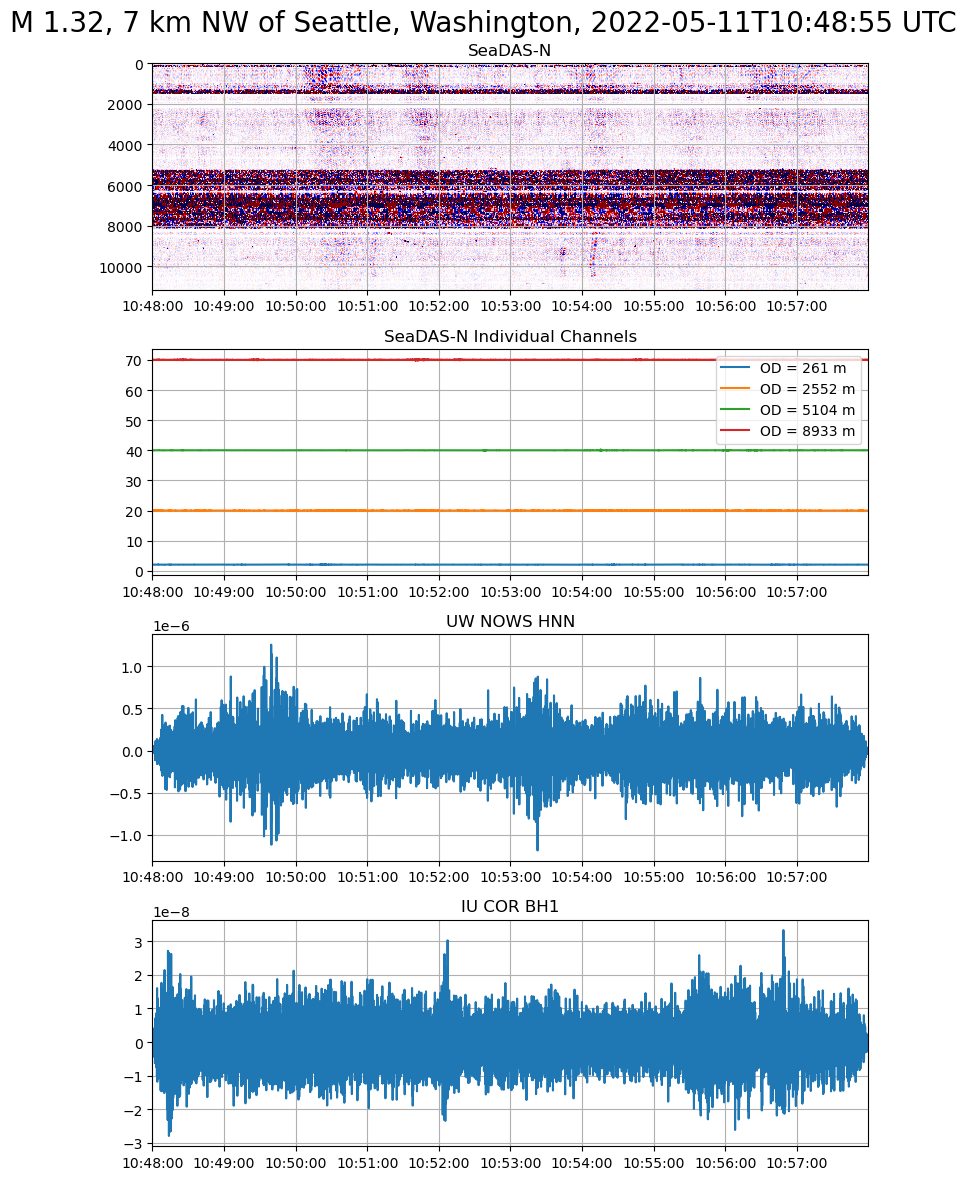

In [25]:
# nombre = f"figures/{event_df.iloc[catalog_index]['Evid']}.png"
# local_earthquake_quicklook(dates,data_filt,st,st2,x_max,event_df,catalog_index,filename=nombre)


stitle=f"M {this_event['magnitude'].to_numpy()[0]}, "\
       f"{this_event['location'].to_numpy()[0]}, "\
       f"{str(this_event['time'].to_numpy()[0])[0:-10]} UTC"


local_earthquake_quicklook(dates,data_filt,st,st2,x_max,
                           stitle,das_vmax=0.02,
                           network_name=network_name)

In [26]:
this_event.url.to_list()[0]

'https://earthquake.usgs.gov/earthquakes/eventpage/uw61830387'

In [27]:
# from tqdm import tqdm
# xc = np.zeros((2*18000-1,174))

# for i in tqdm(range(174)):
#     xc[:,i] = np.correlate( data_filt[:,30]/max(data_filt[:,30]),
#                             data_filt[:,i*10]/max(data_filt[:,i*10]),
#                             mode='full')

In [28]:
from tqdm import tqdm
xc = np.zeros((2*18000-1,174))

for i in tqdm(range(174)):
    xc[:,i] = np.correlate(np.sign(data_filt[:,30]),
                           np.sign(data_filt[:,i*10]),
                           mode='full')

ModuleNotFoundError: No module named 'tqdm'

NameError: name 'xc' is not defined

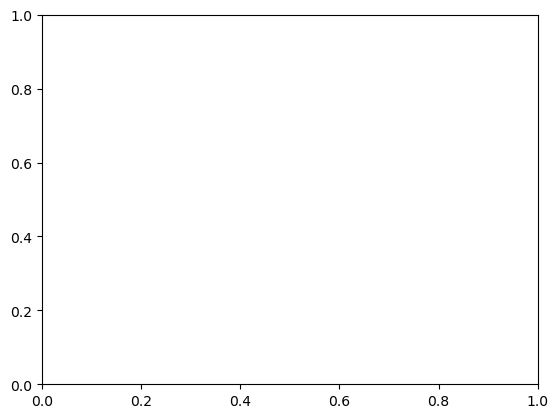

In [29]:
fig,ax=plt.subplots()
plt.imshow(xc.T,aspect='auto',vmin=-1000,vmax=1000)
# plt.plot(data_filt[:,30])
# plt.plot(data_filt[:,40])
plt.xlim(18000-1e3,18000+1e3)
plt.show()

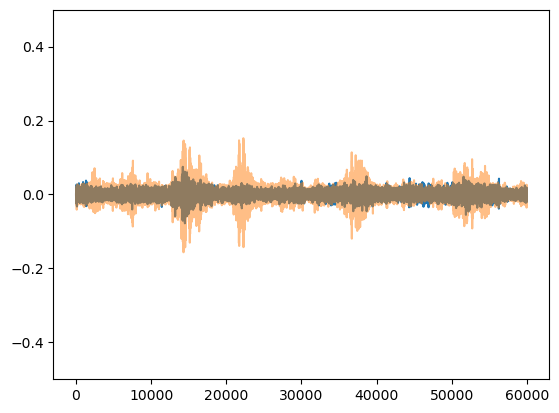

In [30]:
fig,ax=plt.subplots()
# plt.imshow(xc.T,aspect='auto',vmin=-0.1,vmax=0.1)
plt.plot(data_filt[:,40])
plt.plot(data_filt[:,30],alpha=0.5)
#plt.xlim(7050,7200)
plt.ylim(-0.5,0.5)
plt.show()

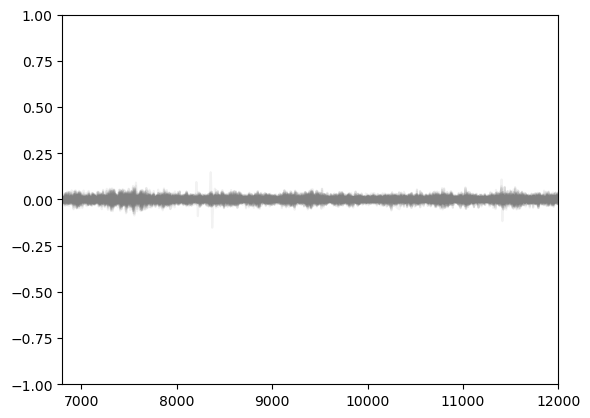

In [31]:
fig,ax=plt.subplots()

for i in data_filt.T[30:100]:
    ax.plot(i, c='grey', alpha=0.1)
plt.xlim([6800,12000])
plt.ylim([-1,1])
plt.show()

In [33]:

af = fft(data_filt[:,11])
bf = fft(data_filt[:,60])
c = ifft(af * scipy.conj(bf))

time_shift = np.argmax(c)
print(time_shift)

864


/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.conj is deprecated and will be removed in SciPy 2.0.0, use numpy.conj instead
  """


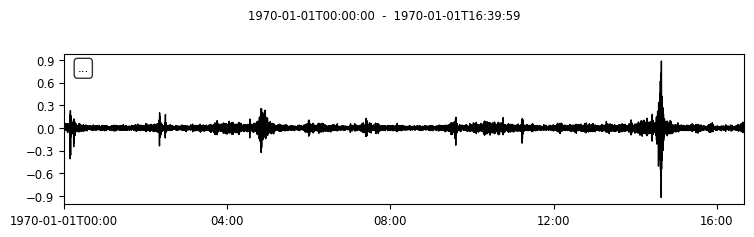

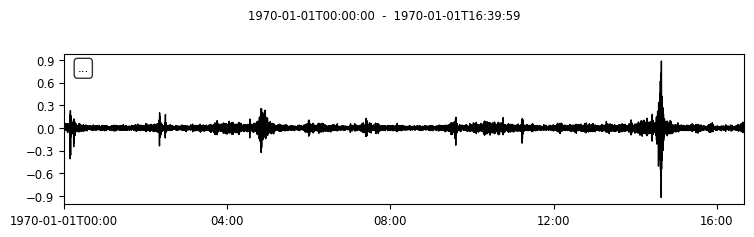

In [34]:

das_trace = obspy.core.trace.Trace(data_filt[:,200])
das_trace.plot()

In [35]:
das_trace.stats['sampling_rate'] = 100.0

In [36]:
das_trace.stats.sampling_rate

100.0

/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/obspy/signal/trigger.py:183: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.ascontiguousarray(data, dtype=np.float64)


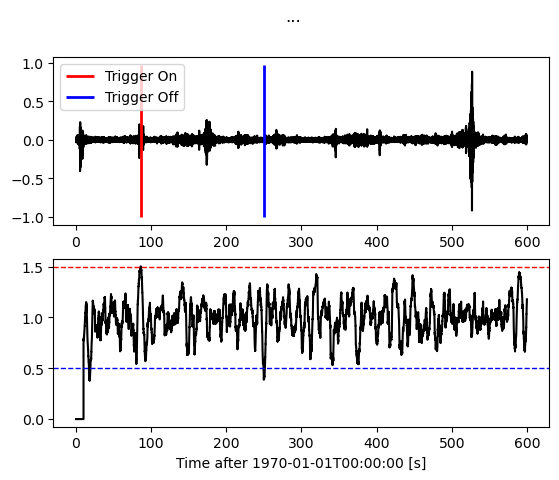

In [37]:


df = das_trace.stats.sampling_rate
cft = classic_sta_lta(c, int(6 * df), int(10 * df))

plot_trigger(das_trace, cft, 1.5, 0.5)

In [1]:
#print(cft.argmax())

In [257]:
channel_picks = []
chan_number = 0

for channel in data_filt.T:
    das_trace = obspy.core.trace.Trace(channel)
    das_trace.stats['sampling_rate'] = 100.0
    df = das_trace.stats.sampling_rate
    cft = classic_sta_lta(das_trace, int(5 * df), int(10 * df))
    
    channel_picks.append( cft.argmax() / 100 )
    
    chan_number +=1

Text(0.5, 0, 'Channel Number')

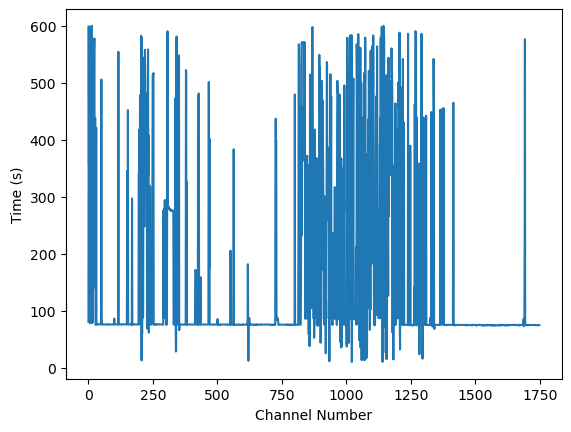

In [259]:
plt.plot(channel_picks)
#plt.ylim([7000,8000])
plt.ylabel('Time (s)')
plt.xlabel('Channel Number')

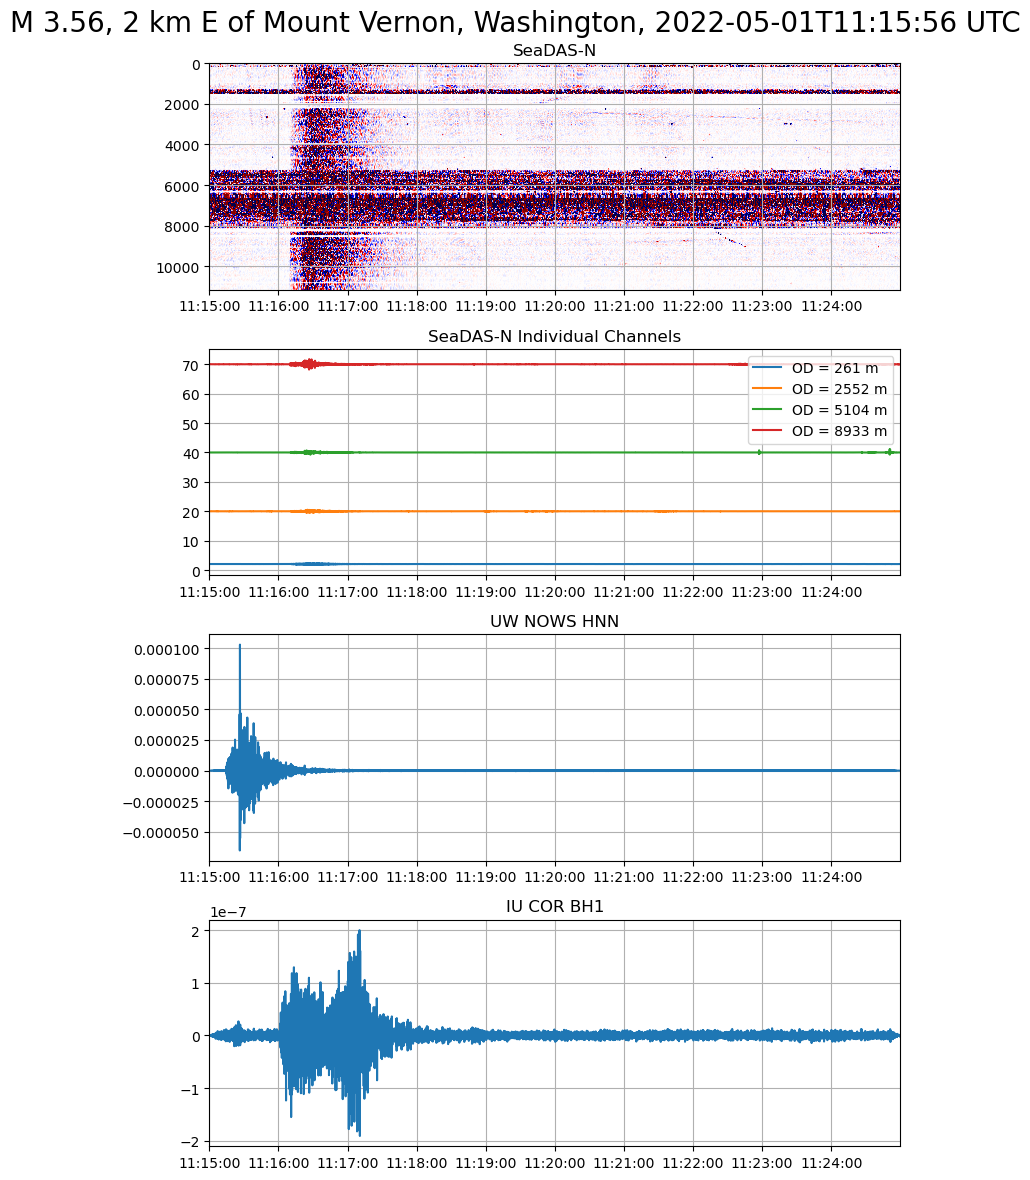

In [261]:
local_earthquake_quicklook(dates,data_filt,st,st2,x_max,
                           stitle,das_vmax=0.02,
                           network_name=network_name)

# Routine for picking wave arrival times from lcoal events

In [22]:
#Function that returns the DAS data according to USGS earthquake events

def das_downloader(this_id, cab='seadasn'):
    this_event = event_df[event_df.id==this_id]
    t0 = this_event['time'].iloc[0].to_pydatetime()

    cable = cab
    record_length = 3 #minutes
    
    try:
        if cable == 'seadasn':
            prefix = 'seadasn'
            network_name = 'SeaDAS-N'
            if t0 < datetime.datetime(2022, 6, 20, 0, 0, 0):
                datastore='/data/data0/seadasn_2022-03-17_2022-06-20/'
            else:
                datastore='/data/data7/seadasn_2022-06-21_2022-10-06/'
#             else:
#                 datastore='/data/data4/seadasn_2021-11-01_2021-11-05/'
#             else:
#                 datastore='/data/data1/seadasn_2021-10-13_2021-11-01/'

        elif cable == 'whidbey':
            prefix = 'whidbey'
            network_name='Whidbey-DAS'
            datastore = '/data/data5/Converted/'

        data,dates,attrs = open_sintela_file(prefix,
                                             t0,
                                             datastore,
                                             number_of_files=record_length,
                                             verbose=True)
        x_max=data.shape[1] * attrs['SpatialSamplingInterval']
        
        low_cut = 2
        hi_cut = 10

        b,a = butter(2,(low_cut,hi_cut),'bp',fs=attrs['MaximumFrequency']*2)
        data_filt = filtfilt(b,a,data,axis=0)
    
    except:
        print('No data for this quake!')
        data = None
        dates = None
        attrs = None
        x_max = None
        data_filt = None
    return data, dates, attrs, x_max, this_id, data_filt,t0

In [230]:

#Load events (specify search radius)
events = search(starttime = datetime.datetime(2022, 3, 17, 0, 0), 
                endtime   = datetime.datetime.now(),
                maxradiuskm=100, 
                latitude=47.60, 
                longitude=-122.33)



#Get list of USGS events
event_df = get_summary_data_frame(events)
event_df = event_df.sort_values(by=['magnitude'],ascending=False)

#Create a list with the event id numbers for data download
event_df = event_df[(event_df['depth']) > 2.0 & (event_df['magnitude'] > 2.5)]
culled = len(events)-len(event_df)
earthquake_list = event_df['id'].values.tolist()
print("Found %s events" % len(events),"and culled %s"%culled, "events due to depth constraints")
event_df

TypeError: Cannot perform 'rand_' with a dtyped [bool] array and scalar of type [bool]

In [215]:
arrival_picks = {}
das_quake_attrs = {}

for i in earthquake_list:
    
    data, dates, attrs, x_max, this_id, data_filt,t0 = das_downloader(i)
    if attrs != None:  
        if attrs['NumberOfLoci'] == 4556:
            das_quake_attrs[this_id] = attrs
            if  x_max != None:
                channel_picks = []
                chan_number = 0
                for channel in data_filt.T:
                    das_trace = obspy.core.trace.Trace(channel)
                    das_trace.stats['sampling_rate'] = 100.0
                    df = das_trace.stats.sampling_rate
                    cft = recursive_sta_lta(das_trace, int(0.5 * df), int(20 * df))
                    channel_picks.append(  (cft.argmax() / attrs['PulseRate'] - (t0 - dates[0] ).total_seconds() ))
                    chan_number +=1
                plot_trigger(das_trace, cft,2.5,0.75)
            arrival_picks[str(i)] = channel_picks
            print(this_id)

/data/data7/seadasn_2022-06-21_2022-10-06/seadasn_2022-09-08_08-08*.h5
No data for this quake!
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-01_11-15*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-01_11-16*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-01_11-17*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-17_08-07*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-17_08-08*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-17_08-09*.h5
/data/data7/seadasn_2022-06-21_2022-10-06/seadasn_2022-08-04_13-22*.h5
No data for this quake!
/data/data7/seadasn_2022-06-21_2022-10-06/seadasn_2022-06-25_20-18*.h5
/data/data7/seadasn_2022-06-21_2022-10-06/seadasn_2022-06-25_20-19*.h5
/data/data7/seadasn_2022-06-21_2022-10-06/seadasn_2022-06-25_20-20*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-06-11_23-57*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-06-11_23-58*.h5
/data/data0/seadasn_2022-03-1

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


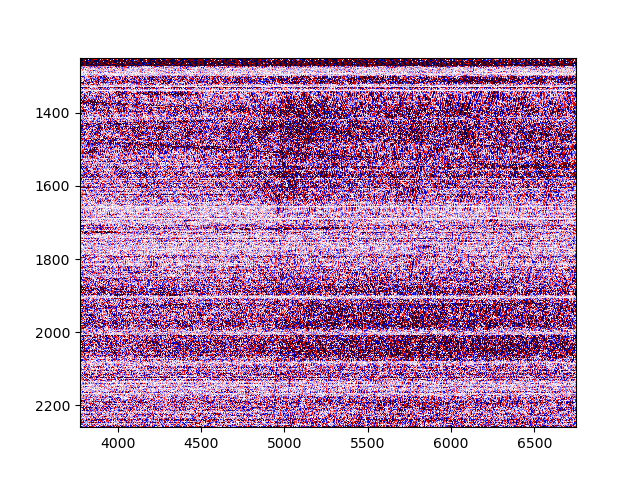

In [226]:

plt.figure()
plt.imshow(data_filt.T,aspect='auto',cmap='seismic',vmin=-.05,vmax=.05)


In [225]:
event_df[event_df['id'] == this_id]

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
104,uw61834816,2022-04-28 03:48:34.590,"7 km ENE of Fall City, Washington",47.603,-121.805333,16.29,2.35,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,90


<IPython.core.display.Javascript object>


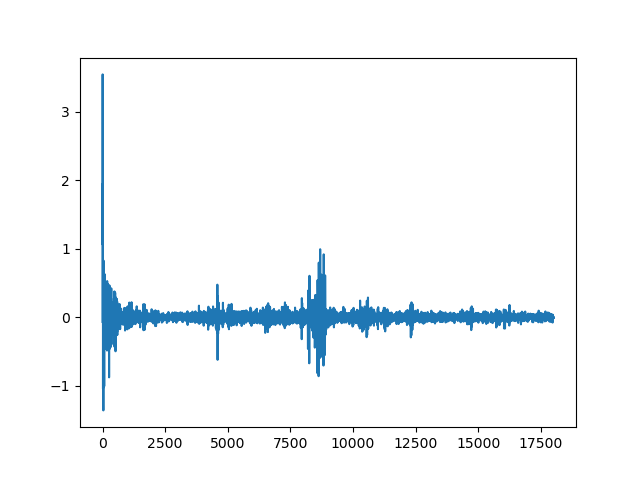

{'AcquisitionId': b'56ab5f25-9099-465a-aec3-55600b1d71ee', 'Build': b'release-5.17:9_P', 'Classification': b'TestClass', 'Comment': b'TestComment', 'CommitHash': b'f9dcdb09c', 'Creator': b'TestAuthor', 'DasInstrumentBox': b'ONYX', 'DetectionAccuracy': b'Incorrect Classification', 'FFID': 0, 'FacilityId': b'ONYX-0203 Fiber 1', 'FiberID': 0, 'GaugeLength': 9.571429252624512, 'GaugeLengthUnit': b'm', 'Hostname': b'ONYX-0203', 'MaximumFrequency': 50.0, 'MeasurementStartTime': b'2022-04-28T03:47:59.996562+00:00', 'MinimumFrequency': 0.0, 'NumberOfLoci': 4556, 'OpticalPath': b'OpticalPath', 'PulseRate': 100.0, 'PulseRateUnit': b'Hz', 'PulseWidth': 20.0, 'PulseWidthUnit': b'ns', 'SoftwareVersion': b'9', 'SpatialSamplingInterval': 6.38095235824585, 'SpatialSamplingIntervalUnit': b'm', 'StartLocusIndex': 0, 'SystemType': b'Xavier', 'TriggeredMeasurement': 0, 'VendorCode': b'Sintela', 'schemaVersion': b'2.0', 'uuid': b'046587c6-d97a-46aa-a500-70cc730544b8'}


In [227]:
plt.figure()
# plt.plot(data_filt[:,1336])
plt.plot(data_filt[:,1500])
print(attrs)

In [143]:
arrival_times_1749 = []

for i in arrival_picks:
    if len(arrival_picks[i]) == 1749:
        #print(i)
        arrival_times_1749.append(arrival_picks[i])

In [340]:
arrival_times_1749 = np.asarray(arrival_times_1749)

In [2]:
plt.imshow(arrival_times_1749, aspect='auto')
plt.colorbar(label = 'Arrival Time (s)')

NameError: name 'plt' is not defined

In [ ]:
# Good events
uw61846087
uw61837027
uw61844597
uw61841392
uw61846447
uw61850701

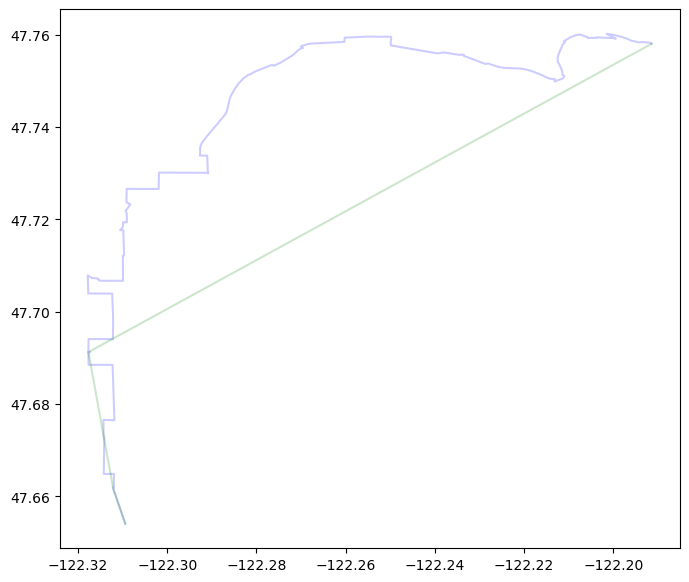

In [83]:
#Load the fiber location and calibration data
fiber_location = pd.read_csv('fiberroute.csv', header=1)
fiber_calibration = pd.read_csv('calibration.csv', header=1)

#Plot
fig, ax = plt.subplots(figsize = (8,7))
ax.plot(fiber_location['Long'], fiber_location['Lat'], zorder=1, alpha= 0.2, c='b')
ax.plot(fiber_calibration['Long'], fiber_calibration['Lat'], zorder=1, alpha= 0.2, c='g')

In [84]:
#Calculate the fiber distance between points in the fiber location file
import geopy.distance
fiber_distance = []

for index, row in fiber_location.iterrows():
    if index == 0 :
        fiber_distance.append(0)
    elif index <= len(fiber_location.index) -1:
        coords_1 = (row['Lat'], row['Long'])
        coords_2 = (fiber_location.iloc[index-1]['Lat'], fiber_location.iloc[index-1]['Long'])
        distance = geopy.distance.geodesic(coords_1, coords_2).m
        fiber_distance.append(distance   + fiber_distance[-1])
        
fiber_location['Fiber Dist'] = fiber_distance

In [85]:
fiber_location

,Lat,Long,Elev,Description,Fiber Dist
0,47.654085,-122.309411,0,NaN,0.000000
1,47.661686,-122.312116,0,NaN,869.191066
2,47.661686,-122.312127,0,NaN,870.017298
3,47.661742,-122.312127,0,NaN,876.243587
4,47.661742,-122.312036,0,NaN,883.078767
...,...,...,...,...,...
206,47.758301,-122.194216,0,NaN,24241.622680
207,47.758385,-122.193560,0,NaN,24291.684023
208,47.758206,-122.191504,0,NaN,24447.108566
209,47.757981,-122.191496,0,NaN,24472.132519


In [86]:
fiber_calibration

,Lat,Long,Elev,Opt Dist,Scale Name,Scale Number,Description,State,Purpose,Scale Suffix
0,47.654085,-122.309411,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,47.661686,-122.312116,0.0,1500.0,NaN,NaN,NaN,NaN,NaN,NaN
2,47.691258,-122.317682,0.0,6400.0,NaN,NaN,NaN,NaN,NaN,NaN
3,47.757981,-122.191467,0.0,29043.0,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
opt_dis_merge = []

for index_fib, row_fib in fiber_location.iterrows():
    l = []
    for index_cal, row_cal in fiber_calibration.iterrows():
        if row_fib['Lat'] == row_cal['Lat'] and row_fib['Long'] == row_cal['Long']:
            l.append(row_cal['Opt Dist'])
        else:
            pass
    if l:
        opt_dis_merge.append(l[0])
    else:
        opt_dis_merge.append(np.nan)

In [88]:
fiber_location['Opt Dist'] = opt_dis_merge
dis_interp = fiber_location['Opt Dist'].interpolate(method='linear', fill_value='extrapolate')
fiber_location['Opt Dist Interp'] = dis_interp

fiber_location

,Lat,Long,Elev,Description,Fiber Dist,Opt Dist,Opt Dist Interp
0,47.654085,-122.309411,0,NaN,0.000000,1.0,1.000000
1,47.661686,-122.312116,0,NaN,869.191066,1500.0,1500.000000
2,47.661686,-122.312127,0,NaN,870.017298,NaN,1713.043478
3,47.661742,-122.312127,0,NaN,876.243587,NaN,1926.086957
4,47.661742,-122.312036,0,NaN,883.078767,NaN,2139.130435
...,...,...,...,...,...,...,...
206,47.758301,-122.194216,0,NaN,24241.622680,NaN,28553.421622
207,47.758385,-122.193560,0,NaN,24291.684023,NaN,28675.816216
208,47.758206,-122.191504,0,NaN,24447.108566,NaN,28798.210811
209,47.757981,-122.191496,0,NaN,24472.132519,NaN,28920.605405


# Widbey Island Work - 
## Plotting the fiber location and interpolated optical distance

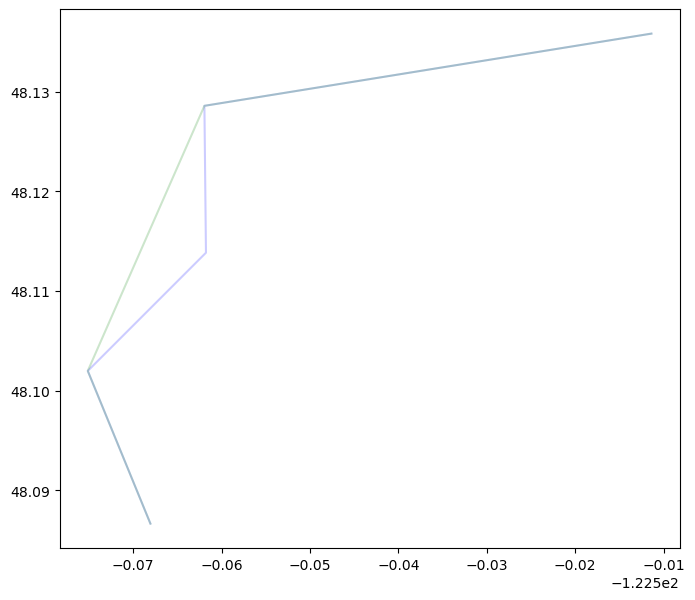

In [56]:
#Load the fiber location and calibration data
fiber_location_w = pd.read_csv('fiberroute_whidbey.csv', header=1)
fiber_calibration_w = pd.read_csv('calibration_whidbey.csv', header=1)

#Plot
fig, ax = plt.subplots(figsize = (8,7))
ax.plot(fiber_location_w['Long'], fiber_location_w['Lat'], zorder=1, alpha= 0.2, c='b')
ax.plot(fiber_calibration_w['Long'], fiber_calibration_w['Lat'], zorder=1, alpha= 0.2, c='g')

In [75]:
import geopy.distance
fiber_distance_w = []

for index, row in fiber_location_w.iterrows():
    if index == 0 :
        fiber_distance_w.append(0)
    elif index <= len(fiber_location_w.index) -1:
        coords_1 = (row['Lat'], row['Long'])
        coords_2 = (fiber_location_w.iloc[index-1]['Lat'], fiber_location_w.iloc[index-1]['Long'])
        distance = geopy.distance.geodesic(coords_1, coords_2).m
        fiber_distance_w.append(distance  + fiber_distance_w[-1])
        
fiber_location_w['Fiber Dist'] = fiber_distance_w

In [76]:
opt_dis_merge_w = []

for index_fib, row_fib in fiber_location_w.iterrows():
    l = []
    for index_cal, row_cal in fiber_calibration.iterrows():
        if row_fib['Lat'] == row_cal['Lat'] and row_fib['Long'] == row_cal['Long']:
            l.append(row_cal['Opt Dist'])
        else:
            pass
    if l:
        opt_dis_merge_w.append(l[0])
    else:
        opt_dis_merge_w.append(np.nan)

In [77]:
fiber_location_w['Opt Dist'] = opt_dis_merge_w
dis_interp_w = fiber_location_w['Opt Dist'].interpolate(method='linear', fill_value='extrapolate')
fiber_location_w['Opt Dist Interp'] = dis_interp_w

fiber_location_w

,Lat,Long,Elev,Description,Fiber Dist,Opt Dist,Opt Dist Interp
0,48.086666,-122.568055,0,NaN,0.000000,0.00,0.00
1,48.101989,-122.575139,0,NaN,1783.640526,3353.20,3353.20
2,48.113849,-122.561772,0,NaN,3435.903037,NaN,5086.71
3,48.128587,-122.561947,0,NaN,5074.712547,6820.22,6820.22
4,48.135833,-122.511389,0,NaN,8923.254259,10975.00,10975.00


In [90]:
#Making a change

In [91]:
#anotha change

In [92]:
#anotha one

In [ ]:
# Parker's change